In [1]:
###########################################################################################
#                                                                                         #
# Import all libraries                                                                    #
#                                                                                         #
###########################################################################################

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [2]:
###########################################################################################
#                                                                                         #
# Reflect the hawaii database and check the tables in it                                  #
#                                                                                         #
###########################################################################################
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [3]:
###########################################################################################
#                                                                                         #
# Table references and Session                                                            #
#                                                                                         #
###########################################################################################
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

session = Session(engine)

In [4]:
###########################################################################################
#                                                                                         #
# Check the contents of the table Measurement                                             #
#                                                                                         #
###########################################################################################
esquema = engine.execute("PRAGMA table_info(measurement)")
for x in esquema:
    print(x)

(0, 'id', 'INTEGER', 1, None, 1)
(1, 'station', 'TEXT', 0, None, 0)
(2, 'date', 'TEXT', 0, None, 0)
(3, 'prcp', 'FLOAT', 0, None, 0)
(4, 'tobs', 'FLOAT', 0, None, 0)


In [5]:
###########################################################################################
#                                                                                         #
# Check the contents of the table Station                                                 #
#                                                                                         #
###########################################################################################
esquema = engine.execute("PRAGMA table_info(station)")
for x in esquema:
    print(x)

(0, 'id', 'INTEGER', 1, None, 1)
(1, 'station', 'TEXT', 0, None, 0)
(2, 'name', 'TEXT', 0, None, 0)
(3, 'latitude', 'FLOAT', 0, None, 0)
(4, 'longitude', 'FLOAT', 0, None, 0)
(5, 'elevation', 'FLOAT', 0, None, 0)


# Exploratory Climate Analysis

In [6]:
###########################################################################################
#                                                                                         #
#  Precipitation Analysis                                                                 #
#  Design a query to retrieve the last 12 months of precipitation data and plot the       #
#  results                                                                                #
#                                                                                         #
###########################################################################################

# Calculate the date 1 year ago from the last data point in the database
lastDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
lastDateDT = dt.datetime.strptime(lastDate[0], "%Y-%m-%d")
twelveMonthsAgo = lastDateDT - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data = []
for row in session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= twelveMonthsAgo).all():
    data.append(row)

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
dataPD = pd.DataFrame(data).sort_values(by=['date'])
dataPD.columns = ['date', 'precipitation']
dataPD.dropna()
dataPD.set_index("date", inplace=True)

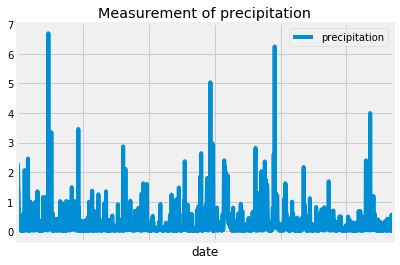

<Figure size 432x288 with 0 Axes>

In [7]:
# Use Pandas Plotting with Matplotlib to plot the data
dataPD[dataPD['precipitation'] > 0].plot(title='Measurement of precipitation')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.show()
plt.savefig("./Resources/Precipitations.png")

In [8]:
###########################################################################################
#                                                                                         #
# Use Pandas to calcualte the summary statistics for the precipitation data               #
#                                                                                         #
###########################################################################################

print(f'''
Summary Statistics
-------------------------------------
Rows used to calculate (Date/Station): {dataPD.count()[0]}
Average precipitation: {round(dataPD.mean()[0],2)}
Max precipitation: {dataPD.max()[0]}
Min precipitation: {dataPD.min()[0]}
''')


Summary Statistics
-------------------------------------
Rows used to calculate (Date/Station): 2015
Average precipitation: 0.18
Max precipitation: 6.7
Min precipitation: 0.0



In [9]:
###########################################################################################
#                                                                                         #
# Design a query to show how many stations are available in this dataset                  #
#                                                                                         #
###########################################################################################

stations = session.query(Station).count()

print(f"There are: {stations} stations")

There are: 9 stations


In [10]:
###########################################################################################
#                                                                                         #
# What are the most active stations? (i.e. what stations have the most rows)?             #
# List the stations and the counts in descending order.                                   #
#                                                                                         #
###########################################################################################

for row in session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all():
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [11]:
###########################################################################################
#                                                                                         #
# Using the station id from the previous query, calculate the lowest temperature recorded #
# highest temperature recorded, and average temperature of the most active station        #
#                                                                                         #
###########################################################################################

mostActiveStation = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]

dataMAS = []
for row in session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == mostActiveStation).all():
    dataMAS.append(row)
dataMASPD = pd.DataFrame(dataMAS)
dataMASPD.set_index("station", inplace=True)

print(f'''
Most Active Station
-------------------------------------
The most active station is: {mostActiveStation}
Lowest temperature recorded: {dataMASPD.min()[0]}
Highest temperature recorded: {dataMASPD.max()[0]}
Average temperature recorded: {round(dataMASPD.mean()[0],2)}
''')


Most Active Station
-------------------------------------
The most active station is: USC00519281
Lowest temperature recorded: 54.0
Highest temperature recorded: 85.0
Average temperature recorded: 71.66



In [12]:
###########################################################################################
#                                                                                         #
# Choose the station with the highest number of temperature observations.                 #
# Query the last 12 months of temperature observation data for this station and plot the  #
# results as a histogram                                                                  #
#                                                                                         #
###########################################################################################

dataMASPlot = []

for row in session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= twelveMonthsAgo, Measurement.station == mostActiveStation).all():
    dataMASPlot.append(row)

dataMASPlotPD = pd.DataFrame(dataMASPlot).sort_values(by=['date'])
dataMASPlotPD.columns = ['date', 'tobs']
dataMASPlotPD.dropna()
dataMASPlotPD.set_index("date", inplace=True)


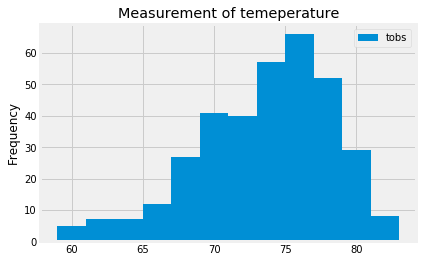

<Figure size 432x288 with 0 Axes>

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
dataMASPlotPD.plot.hist(title='Measurement of temeperature', bins=12)
plt.show()
plt.savefig("./Resources/Temperature.png")

# Temperature Analysis I

In [14]:
###########################################################################################
#                                                                                         #
# Create a database with the CSV files                                                    #
# Import libraries and declare Base                                                       #
#                                                                                         #
###########################################################################################
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import csv
import pandas as pd
from sqlalchemy import create_engine, Table, Column, Integer, MetaData, String, Float, Date, func
from datetime import datetime

In [15]:
###########################################################################################
#                                                                                         #
# Database creation from csv                                                              #
#                                                                                         #
###########################################################################################

engine = create_engine('sqlite:///csv_hawaii.db', echo=True)

metadata = MetaData()
# Define the table with sqlalchemy:
my_table = Table('stations', metadata,
    Column('id', Integer, primary_key=True),
    Column('station', String),             
    Column('name', String),
    Column('latitude', Float),
    Column('longitude', Float),
    Column('elevation', Float)
)

my_table2 = Table('measurements', metadata,
    Column('id', Integer, primary_key=True),
    Column('station', String),             
    Column('date', Date),
    Column('prcp', Float),
    Column('tobs', Float),
)

metadata.create_all(engine)
insert_query = my_table.insert()
insert_query2 = my_table2.insert()


with open('./Resources/hawaii_stations.csv', 'r', encoding="utf-8") as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    next(csv_reader)
    engine.execute(
        insert_query,
        [{ "station": row[0], "name": row[1], "latitude": float(row[2]), "longitude": float(row[3]), "elevation": float(row[4])} 
            for row in csv_reader]
    )

with open('./Resources/hawaii_measurements.csv', 'r', encoding="utf-8") as csvfile2:
    csv_reader2 = csv.reader(csvfile2, delimiter=',')
    next(csv_reader2)
    engine.execute(
        insert_query2,
        [{ "station": row2[0], "date": datetime.strptime(row2[1], "%Y-%m-%d"), "prcp": float(row2[2]), "tobs": float(row2[3])} 
            for row2 in csv_reader2]
    )

2019-11-08 23:41:20,443 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-11-08 23:41:20,444 INFO sqlalchemy.engine.base.Engine ()
2019-11-08 23:41:20,447 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-11-08 23:41:20,448 INFO sqlalchemy.engine.base.Engine ()
2019-11-08 23:41:20,449 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("stations")
2019-11-08 23:41:20,451 INFO sqlalchemy.engine.base.Engine ()
2019-11-08 23:41:20,453 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("measurements")
2019-11-08 23:41:20,455 INFO sqlalchemy.engine.base.Engine ()
2019-11-08 23:41:20,457 INFO sqlalchemy.engine.base.Engine 
CREATE TABLE stations (
	id INTEGER NOT NULL, 
	station VARCHAR, 
	name VARCHAR, 
	latitude FLOAT, 
	longitude FLOAT, 
	elevation FLOAT, 
	PRIMARY KEY (id)
)


2019-11-08 23:41:20,458 INFO sqlalchemy.engine.base.Engine ()
2019-11-08 23:41:20,492 INFO sqlalchemy.engine.bas

In [16]:
###########################################################################################
#                                                                                         #
# Prepare the classes                                                                     #
#                                                                                         #
###########################################################################################

# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

Measurement = Base.classes.measurements
Station = Base.classes.stations

session = Session(engine)

2019-11-08 23:41:26,054 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-11-08 23:41:26,055 INFO sqlalchemy.engine.base.Engine ()
2019-11-08 23:41:26,057 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("measurements")
2019-11-08 23:41:26,058 INFO sqlalchemy.engine.base.Engine ()
2019-11-08 23:41:26,061 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'measurements' AND type = 'table'
2019-11-08 23:41:26,062 INFO sqlalchemy.engine.base.Engine ()
2019-11-08 23:41:26,064 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("measurements")
2019-11-08 23:41:26,066 INFO sqlalchemy.engine.base.Engine ()
2019-11-08 23:41:26,067 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'measurements' AND type = 'table'
2019-11-08 23:41:26,069 INFO sqlalchemy.e

In [17]:
###########################################################################################
#                                                                                         #
# Identify the average temperature in June at all stations across all available years in  #
# the dataset. Do the same for December temperature.                                      #
#                                                                                         #
###########################################################################################

data_june = []
for row in session.query(sqlalchemy.extract('year', Measurement.date).label('yr'), func.avg(Measurement.tobs).label('avg_tobs')).filter(sqlalchemy.extract('month', Measurement.date) == 6).group_by(sqlalchemy.extract('year', Measurement.date)).all():
    data_june.append(row)

data_dec = []
for row in session.query(sqlalchemy.extract('year', Measurement.date).label('yr'), func.avg(Measurement.tobs).label('avg_tobs')).filter(sqlalchemy.extract('month', Measurement.date) == 12).group_by(sqlalchemy.extract('year', Measurement.date)).all():
    data_dec.append(row)


2019-11-08 23:41:30,654 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2019-11-08 23:41:30,663 INFO sqlalchemy.engine.base.Engine SELECT CAST(STRFTIME('%Y', measurements.date) AS INTEGER) AS yr, avg(measurements.tobs) AS avg_tobs 
FROM measurements 
WHERE CAST(STRFTIME('%m', measurements.date) AS INTEGER) = ? GROUP BY CAST(STRFTIME('%Y', measurements.date) AS INTEGER)
2019-11-08 23:41:30,665 INFO sqlalchemy.engine.base.Engine (6,)
2019-11-08 23:41:30,716 INFO sqlalchemy.engine.base.Engine SELECT CAST(STRFTIME('%Y', measurements.date) AS INTEGER) AS yr, avg(measurements.tobs) AS avg_tobs 
FROM measurements 
WHERE CAST(STRFTIME('%m', measurements.date) AS INTEGER) = ? GROUP BY CAST(STRFTIME('%Y', measurements.date) AS INTEGER)
2019-11-08 23:41:30,716 INFO sqlalchemy.engine.base.Engine (12,)


Ttest_indResult(statistic=6.9218571747346616, pvalue=1.4518830376438732e-05)


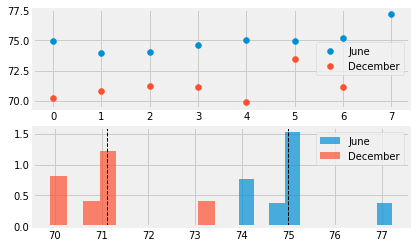

In [18]:
###########################################################################################
#                                                                                         #
# T-test                                                                                  #
#                                                                                         #
###########################################################################################

from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as stats

data_junePD = pd.DataFrame(data_june)
data_decPD = pd.DataFrame(data_dec)

# Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(range(len(data_junePD.avg_tobs)), data_junePD.avg_tobs, label="June")
plt.scatter(range(len(data_decPD.avg_tobs)), data_decPD.avg_tobs, label="December")
plt.legend()

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(data_junePD.avg_tobs, 10, density=True, alpha=0.7, label="June")
plt.hist(data_decPD.avg_tobs, 10, density=True, alpha=0.7, label="December")
plt.axvline(data_junePD.avg_tobs.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(data_decPD.avg_tobs.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()  

print(stats.ttest_ind(data_junePD.avg_tobs, data_decPD.avg_tobs, equal_var=False))

# Temperature Analysis II

In [19]:
###########################################################################################
#                                                                                         #
# This function called `calc_temps` will accept start date and end date in the format     #
# '%Y-%m-%d' and return the minimum, average, and maximum temperatures for that range     #
# of dates                                                                                #
#                                                                                         #
###########################################################################################

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

2019-11-08 23:41:42,023 INFO sqlalchemy.engine.base.Engine SELECT min(measurements.tobs) AS min_1, avg(measurements.tobs) AS avg_1, max(measurements.tobs) AS max_1 
FROM measurements 
WHERE measurements.date >= ? AND measurements.date <= ?
2019-11-08 23:41:42,024 INFO sqlalchemy.engine.base.Engine ('2012-02-28', '2012-03-05')
[(62.0, 69.57142857142857, 74.0)]


In [20]:
###########################################################################################
#                                                                                         #
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax           #
# for your trip using the previous year's data for those same dates.                      #
#                                                                                         #
###########################################################################################

resultado = calc_temps('2016-06-01', '2016-07-05')[0]

resultado

2019-11-08 23:41:46,089 INFO sqlalchemy.engine.base.Engine SELECT min(measurements.tobs) AS min_1, avg(measurements.tobs) AS avg_1, max(measurements.tobs) AS max_1 
FROM measurements 
WHERE measurements.date >= ? AND measurements.date <= ?
2019-11-08 23:41:46,103 INFO sqlalchemy.engine.base.Engine ('2016-06-01', '2016-07-05')


(64.0, 75.42533936651584, 82.0)

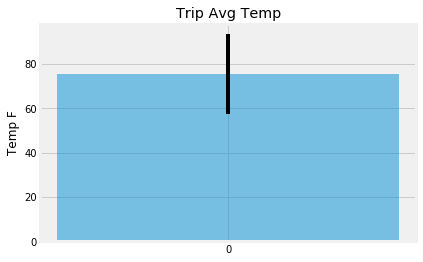

In [21]:
###########################################################################################
#                                                                                         #
# Plot the results from your previous query as a bar chart.                               #
# Use "Trip Avg Temp" as your Title                                                       #
# Use the average temperature for the y value                                             #
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)                        #
#                                                                                         #
###########################################################################################

x_pos = np.arange(1)
CTEs = [resultado[1]]
error = [resultado[2]-resultado[0]]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black')
ax.set_ylabel('Temp F')
ax.set_xticks(x_pos)

ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)

plt.show()

# Daily Rainfall Average

In [23]:
###########################################################################################
#                                                                                         #
# Calculate the total amount of rainfall per weather station for your trip dates using    #
# the previous year's matching dates.                                                     #
# Sort this in descending order by precipitation amount and list the station, name,       #
# latitude, longitude, and elevation                                                      #
#                                                                                         #
###########################################################################################
init_date = '2016-06-01' 
end_date = '2016-07-05'

data_rain = []
for row in session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.date, func.sum(Measurement.prcp).label("total_rain")).join(Measurement, Station.station == Measurement.station).filter(Measurement.date >= init_date, Measurement.date <= end_date).group_by(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.date).all():
    data_rain.append(row)


2019-11-08 23:42:13,852 INFO sqlalchemy.engine.base.Engine SELECT stations.station AS stations_station, stations.name AS stations_name, stations.latitude AS stations_latitude, stations.longitude AS stations_longitude, stations.elevation AS stations_elevation, measurements.date AS measurements_date, sum(measurements.prcp) AS total_rain 
FROM stations JOIN measurements ON stations.station = measurements.station 
WHERE measurements.date >= ? AND measurements.date <= ? GROUP BY stations.station, stations.name, stations.latitude, stations.longitude, stations.elevation, measurements.date
2019-11-08 23:42:13,852 INFO sqlalchemy.engine.base.Engine ('2016-06-01', '2016-07-05')


In [24]:
###########################################################################################
#                                                                                         #
# Create a query that will calculate the daily normals                                    #
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific   #
# month and day)                                                                          #
#                                                                                         #
###########################################################################################

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

2019-11-08 23:42:17,573 INFO sqlalchemy.engine.base.Engine SELECT min(measurements.tobs) AS min_1, avg(measurements.tobs) AS avg_1, max(measurements.tobs) AS max_1 
FROM measurements 
WHERE strftime(?, measurements.date) = ?
2019-11-08 23:42:17,575 INFO sqlalchemy.engine.base.Engine ('%m-%d', '01-01')


[(62.0, 69.15384615384616, 77.0)]

In [25]:
###########################################################################################
#                                                                                         #
# Calculate the daily normals for your trip                                               #
#                                                                                         #
###########################################################################################

# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
init_date = '2016-06-01' 
end_date = '2016-07-05'

# Use the start and end date to create a range of dates
range_dates = pd.date_range(init_date, end_date)

# Stip off the year and save a list of %m-%d strings
list_str = []
for x in range_dates:
    if len(str(x.month)) == 1:
        m = f"0{x.month}"
    else:
        m = f"{x.month}"
        
    if len(str(x.day)) == 1:
        d = f"0{x.day}"
    else:
        d = f"{x.day}"
        
    list_str.append(f"{m}-{d}")
                    
# Loop through the list of %m-%d strings and calculate the normals for each date
for nor in list_str:
    normals.append(daily_normals(nor)[0])

2019-11-08 23:42:22,287 INFO sqlalchemy.engine.base.Engine SELECT min(measurements.tobs) AS min_1, avg(measurements.tobs) AS avg_1, max(measurements.tobs) AS max_1 
FROM measurements 
WHERE strftime(?, measurements.date) = ?
2019-11-08 23:42:22,288 INFO sqlalchemy.engine.base.Engine ('%m-%d', '06-01')
2019-11-08 23:42:22,326 INFO sqlalchemy.engine.base.Engine SELECT min(measurements.tobs) AS min_1, avg(measurements.tobs) AS avg_1, max(measurements.tobs) AS max_1 
FROM measurements 
WHERE strftime(?, measurements.date) = ?
2019-11-08 23:42:22,328 INFO sqlalchemy.engine.base.Engine ('%m-%d', '06-02')
2019-11-08 23:42:22,360 INFO sqlalchemy.engine.base.Engine SELECT min(measurements.tobs) AS min_1, avg(measurements.tobs) AS avg_1, max(measurements.tobs) AS max_1 
FROM measurements 
WHERE strftime(?, measurements.date) = ?
2019-11-08 23:42:22,360 INFO sqlalchemy.engine.base.Engine ('%m-%d', '06-03')
2019-11-08 23:42:22,409 INFO sqlalchemy.engine.base.Engine SELECT min(measurements.tobs) AS

2019-11-08 23:42:23,073 INFO sqlalchemy.engine.base.Engine ('%m-%d', '06-28')
2019-11-08 23:42:23,097 INFO sqlalchemy.engine.base.Engine SELECT min(measurements.tobs) AS min_1, avg(measurements.tobs) AS avg_1, max(measurements.tobs) AS max_1 
FROM measurements 
WHERE strftime(?, measurements.date) = ?
2019-11-08 23:42:23,097 INFO sqlalchemy.engine.base.Engine ('%m-%d', '06-29')
2019-11-08 23:42:23,123 INFO sqlalchemy.engine.base.Engine SELECT min(measurements.tobs) AS min_1, avg(measurements.tobs) AS avg_1, max(measurements.tobs) AS max_1 
FROM measurements 
WHERE strftime(?, measurements.date) = ?
2019-11-08 23:42:23,123 INFO sqlalchemy.engine.base.Engine ('%m-%d', '06-30')
2019-11-08 23:42:23,145 INFO sqlalchemy.engine.base.Engine SELECT min(measurements.tobs) AS min_1, avg(measurements.tobs) AS avg_1, max(measurements.tobs) AS max_1 
FROM measurements 
WHERE strftime(?, measurements.date) = ?
2019-11-08 23:42:23,145 INFO sqlalchemy.engine.base.Engine ('%m-%d', '07-01')
2019-11-08 23

In [26]:
###########################################################################################
#                                                                                         #
# Change datetime objects for strings, so the area plot can work                          #
#                                                                                         #
###########################################################################################
range_dates_str =[]

for ee in range_dates:
    range_dates_str.append(str(ee)[0:10])

In [27]:
###########################################################################################
#                                                                                         #
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range  #
# as the `date` index                                                                     #
#                                                                                         #
###########################################################################################


labels = ['tmin', 'tavg', 'tmax']
normals_pd = pd.DataFrame.from_records(normals, columns=labels)

normals_pd['date'] = range_dates_str

normals_pd.set_index('date')

,tmin,tavg,tmax
date,,,
2016-06-01,64.0,74.614035,81.0
2016-06-02,65.0,74.400000,81.0
2016-06-03,65.0,74.034483,80.0
2016-06-04,65.0,73.818182,81.0
2016-06-05,68.0,74.854545,81.0
2016-06-06,70.0,75.175439,80.0
2016-06-07,68.0,75.071429,81.0
2016-06-08,70.0,75.586207,81.0
2016-06-09,69.0,75.152542,81.0


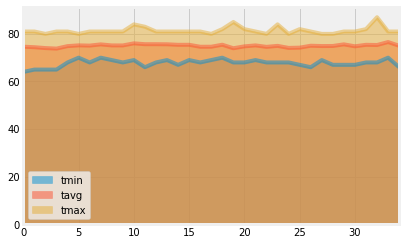

In [28]:
###########################################################################################
#                                                                                         #
# Plot the daily normals as an area plot with `stacked=False`                             #
#                                                                                         #
###########################################################################################
normals_pd.plot.area(stacked=False)
